In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
#import talib
from sklearn.cluster import KMeans

from pandas_datareader import data as web

In [ ]:
#Simple moving average (SMA)
def SMA(data, period=21, column='Close'):
    return data[column].rolling(window=period).mean()

#Exponencial moving average (EMA)
def EMA(data, period=21, column='Close'):
    return data[column].ewm(span=period, adjust = False).mean()

#Moving Average Convergence/Divergence (MACD):
def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
    
    ShortEMA = EMA(data, period_short, column=column)
    LongEMA = EMA(data, period_long, column=column)
    data['MACD'] = ShortEMA - LongEMA
    data['Signal_Line'] = EMA(data, period_signal, column='MACD')

    return data

#Relative Strength Index (RSI)
def RSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta[1:]

    up = delta.copy()
    down = delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    data['Up'] = up
    data['Down'] = down

    AVG_Gain = SMA(data, period, column='Up')
    AVG_Loss = abs(SMA(data, period, column='Down'))

    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0/(1.0 + RS))
    
    data['RSI'] = RSI

    return data

#On Balance Volume (OBV)
def OBV(data, column_pr='Close', column_vol='Volume'):
    data['OBV'] = np.where(df[column_pr] > df[column_pr].shift(1), df[column_vol], np.where(df[column_pr] < df[column_pr].shift(1), -df[column_vol], 0)).cumsum()

    return data

def Bollinger(data, period=14, deviation=2, column='Close'):
    data['BB_up'] = data[column].rolling(period).mean() + deviation * data[column].rolling(period).std()
    data['BB_mid'] = data[column].rolling(period).mean()
    data['BB_dn'] = data[column].rolling(period).mean() - deviation * data[column].rolling(period).std()

    return(data)
    

def Price_ROC(data, period=14, column='Close'):
    
    if period >= 1:

        res = np.zeros(period)

        for i in range(period, len(data)):
            roc = np.array([(data[column].iloc[i] - data[column].iloc[i-period]) / data[column].iloc[i-period] * 100])
            res = np.append(res, roc)

        #prices['momentum'] = pd.Series(res_mom)
        #result = pd.Series(res)
        data['ROC'] = pd.Series(res)
    else:
        print('Period cannot be less than 1.')

    return(data)

def Williams_R(data, period=14, column='Close'):
   
    data['L_period'] = data['Low'].rolling(window=period).min()

    #Create the "H_period" column in the DataFrame
    data['H_period'] = data['High'].rolling(window=period).max()

    #Create the "%R" column in the DataFrame
    data['Williams'] = (data[column] - data['H_period']) / (data['H_period'] - data['L_period']) * 100

    data.drop(['L_period'], axis=1, inplace=True)
    data.drop(['H_period'], axis=1, inplace=True)

    return(data)

def Stochastic(data, period=14, period_ma=3, column='Close'):
   
    data['L_period'] = data['Low'].rolling(window=period).min()

    #Create the "H_period" column in the DataFrame
    data['H_period'] = data['High'].rolling(window=period).max()

    #Create the "%K" column in the DataFrame
    data['%K'] = 100*((data[column] - data['L_period']) / (data['H_period'] - data['L_period']))

    #Create the "%D" column in the DataFrame
    data['%D'] = data['%K'].rolling(window=period_ma).mean()

    data.drop(['L_period'], axis=1, inplace=True)
    data.drop(['H_period'], axis=1, inplace=True)

    return(data)

In [ ]:
ticker = 'NEM'

end_date = datetime.now()
#start_date = datetime(end_date.year-YEARS, end_date.month, end_date.day)
start_date = datetime(2010, 1, 1)

interval ='d'

In [ ]:
df = pd.DataFrame()

df['Open'] = web.get_data_yahoo(ticker, start=start_date, end=end_date, interval=interval)['Open']
df['High'] = web.get_data_yahoo(ticker, start=start_date, end=end_date, interval=interval)['High']
df['Low'] = web.get_data_yahoo(ticker, start=start_date, end=end_date, interval=interval)['Low']
df['Close'] = web.get_data_yahoo(ticker, start=start_date, end=end_date, interval=interval)['Close']
df['Volume'] = web.get_data_yahoo(ticker, start=start_date, end=end_date, interval=interval)['Volume']

In [ ]:
#Call the functions
MACD(df)
RSI(df)
OBV(df)
Bollinger(df)
Price_ROC(df)
Williams_R(df)
Stochastic(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)

df['Vol'] = df['Volume'] / df['Volume'].rolling(20).mean()
df['Ret'] = df['Open'].shift(-2) - df['Open'].shift(-1)
df['Target'] = 0
df = df[30:]

In [ ]:
df.head()

,Open,High,Low,Close,Volume,MACD,Signal_Line,Up,Down,RSI,OBV,BB_up,BB_mid,BB_dn,ROC,Williams,%K,%D,SMA,EMA,Vol,Ret,Target
Date,,,,,,,,,,,,,,,,,,,,,,,
2010-02-17,47.320000,47.860001,46.919998,47.240002,12083800.0,-0.127815,-0.537723,0.000000,-0.179996,59.327236,-45145800.0,48.231769,45.486429,42.741089,NaN,-14.119908,85.880092,88.518825,45.385238,46.133841,1.094541,0.459999,0
2010-02-18,47.299999,48.950001,47.299999,48.410000,10410600.0,0.063857,-0.417407,1.169998,0.000000,62.759821,-34735200.0,48.810205,45.802143,42.794081,NaN,-8.780501,91.219499,88.820413,45.383810,46.340765,0.950428,0.810001,0
2010-02-19,47.759998,49.000000,47.470001,48.540001,8567900.0,0.223669,-0.289192,0.130001,0.000000,67.401978,-26167300.0,49.033162,46.207857,43.382552,NaN,-7.809832,92.190168,89.763253,45.485238,46.540695,0.807644,-1.009998,0
2010-02-22,48.570000,48.689999,47.459999,47.730000,6265300.0,0.281714,-0.175011,0.000000,-0.810001,57.577858,-32432600.0,49.271620,46.364286,43.456951,NaN,-21.561979,78.438021,87.282563,45.641905,46.648814,0.610127,-1.220001,0
2010-02-23,47.560001,47.959999,46.090000,46.580002,8061600.0,0.232243,-0.093560,0.000000,-1.149998,54.272677,-40494200.0,49.297003,46.457857,43.618712,NaN,-41.086561,58.913439,76.513876,45.744286,46.642558,0.786371,0.450001,0


In [ ]:
df_train = df[df.index < datetime(2018,1,1)]
df_test = df[df.index >= datetime(2018,1,1)]

In [ ]:
df_train.shape, df_test.shape

((1983, 23), (833, 23))

In [ ]:
df_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal_Line', 'Up',
       'Down', 'RSI', 'OBV', 'BB_up', 'BB_mid', 'BB_dn', 'ROC', 'Williams',
       '%K', '%D', 'SMA', 'EMA', 'Vol', 'Ret', 'Target'],
      dtype='object')

In [ ]:
features = ['Vol', 'RSI']

X = df_train[features]

kmeans = KMeans(n_clusters=3).fit(X)
y_kmeans = kmeans.predict(X)
df_train['Tar'] = y_kmeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


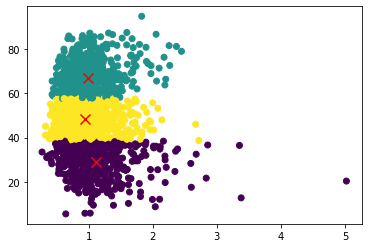

In [ ]:
# --------------------------
#  Plot Training
#
centers = kmeans.cluster_centers_
plt.scatter(df_train['Vol'],df_train['RSI'],c=y_kmeans)
plt.scatter(centers[:,0],centers[:,1],c='red',s=100,marker='x')
plt.show()

In [ ]:
# -------------------------------
#  K Means - Testing
#
x = df_test[features]
y_kmeans = kmeans.predict(x)
df_test['Tar'] = y_kmeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


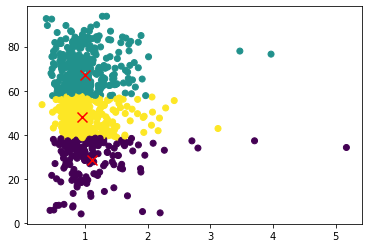

In [ ]:
# --------------------------------
#  Plot Testing
#
plt.scatter(df_test['Vol'],df_test['RSI'],c=y_kmeans)
plt.scatter(centers[:,0],centers[:,1],c='red',s=100,marker='x')
plt.show()

In [ ]:
# ------------------------------------------
#  Compare Training and Testing
#
print("Total Points Earned by Cluster Prediction")

print("Cluster 1 Train: %.2f\tCluster 1 Test: %2.f" % (df_train['Ret'].loc[df_train['Tar'] == 0].sum(),df_test['Ret'].loc[df_test['Tar'] == 0].sum()))

print("Cluster 2 Train: %.2f\tCluster 2 Test: %.2f" % (df_train['Ret'].loc[df_train['Tar'] == 1].sum(),df_test['Ret'].loc[df_test['Tar'] == 1].sum()))

print("Cluster 3 Train: %.2f\tCluster 3 Test: %.2f" % (df_train['Ret'].loc[df_train['Tar'] == 2].sum(),df_test['Ret'].loc[df_test['Tar'] == 2].sum()))

Total Points Earned by Cluster Prediction
Cluster 1 Train: 15.12	Cluster 1 Test: 25
Cluster 2 Train: -13.61	Cluster 2 Test: -10.12
Cluster 3 Train: -10.60	Cluster 3 Test: 13.46


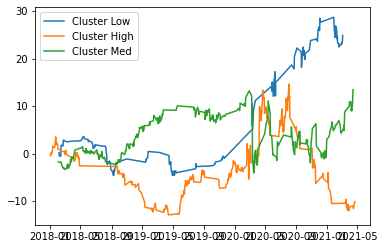

In [ ]:
# ------------------------------
#  Equity Curves
#
plt.plot(np.cumsum(df_test['Ret'].loc[df_test['Tar'] == 0]),label='Cluster Low')
plt.plot(np.cumsum(df_test['Ret'].loc[df_test['Tar'] == 1]),label='Cluster High')
plt.plot(np.cumsum(df_test['Ret'].loc[df_test['Tar'] == 2]),label='Cluster Med')
plt.legend()
plt.show()